In [1]:
# ─── Cell 1: Patch the mean warning and silence logging ───
import warnings, numpy as np, logging
from gluonts.model import forecast as _fm

# Silence the specific UserWarning
warnings.filterwarnings(
    "ignore",
    message=r"The mean prediction is not stored in the forecast data; the median is being returned instead\. This behaviour may change in the future\."
)
# Disable all WARNING and below from all loggers (including GluonTS internals)
logging.disable(logging.WARNING)

# Override .mean on the original classes (in-place)
def _silent_mean(self):
    fd = getattr(self, "_forecast_dict", {})
    if "mean" in fd:
        return fd["mean"]
    if hasattr(self, "samples"):
        return np.median(self.samples, axis=0)
    return self.quantile("p50")

_fm.SampleForecast.mean   = property(_silent_mean)
_fm.QuantileForecast.mean = property(_silent_mean)
# ────────────────────────────────────────────────────────────

In [2]:
# ─── Cell 2: Core imports ───
import torch
import time
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator
import optuna
from optuna.samplers import TPESampler

from pytorch_lightning.utilities.model_summary import ModelSummary
# ─────────────────────────

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

prediction_length = 24
context_length = 168
window_length = context_length + prediction_length
freq = "1h"

def get_electricity_dataset(csv_path: str, total_samples=500_000):
    df = pd.read_csv(csv_path, index_col=0)
    df["date"] = pd.to_datetime(df["date"])

    # Encode categorical ID
    label_encoder = LabelEncoder()
    df["categorical_id"] = label_encoder.fit_transform(df["categorical_id"].astype(str))

    # Limit data to Jan 1 – Sep 1, 2014 (i.e., days_from_start < 1339)
    full_range_df = df[df["days_from_start"] < 1339]

    # Sample sliding windows over full range
    def sample_windows(subset_df):
        samples = []
        for entity_id, group in subset_df.groupby("id"):
            group = group.sort_values("date")
            if len(group) < window_length:
                continue

            scaler = StandardScaler().fit(group[["power_usage", "hour", "day_of_week", "t"]].values)
            target_scaler = StandardScaler().fit(group[["power_usage"]].values)

            features = scaler.transform(group[["power_usage", "hour", "day_of_week", "t"]].values)
            targets = target_scaler.transform(group[["power_usage"]].values).flatten().astype(np.float32)

            feat_hour = features[:, 1].astype(np.float32)
            feat_dow = features[:, 2].astype(np.float32)
            feat_time = features[:, 3].astype(np.float32)

            static_cat = [group["categorical_id"].iloc[0]]
            dates = group["date"].values

            for i in range(0, len(group) - window_length + 1):
                samples.append({
                    FieldName.START: dates[i],
                    FieldName.TARGET: targets[i:i + window_length],
                    FieldName.FEAT_STATIC_CAT: static_cat,
                    FieldName.FEAT_DYNAMIC_REAL: [
                        feat_hour[i:i + window_length],
                        feat_dow[i:i + window_length],
                        feat_time[i:i + window_length],
                    ],
                })

        return samples

    # Step 1: All possible windows up to Sep 1
    all_samples = sample_windows(full_range_df)

    # Step 2: Shuffle and take 500,000 total
    np.random.shuffle(all_samples)
    all_samples = all_samples[:total_samples]

    # Step 3: Split into 450k train / 50k val
    train_samples = all_samples[:450_000]
    val_samples = all_samples[450_000:]

    # Step 4: Test set = fixed last 7 days (same as official code)
    test_df = df[df["days_from_start"] >= 1332]
    test_samples = sample_windows(test_df)

    train_ds = ListDataset(train_samples, freq=freq)
    val_ds = ListDataset(val_samples, freq=freq)
    test_ds = ListDataset(test_samples, freq=freq)

    return train_ds, val_ds, test_ds, freq, prediction_length


In [4]:
file_path = "Dataset/Electricity/hourly_electricity.csv"  # Adjust if it's in a subfolder

In [5]:
# ─── Cell 4: Load data & set precision ───
train_ds, val_ds, test_ds, freq, prediction_length = get_electricity_dataset(file_path)

In [ ]:
# Step 3: Define Estimator (PyTorch-based TFT)
estimator = TemporalFusionTransformerEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=168,
    static_cardinalities=[370],
    dynamic_dims=[3],
    past_dynamic_dims=[],
    quantiles=[0.1, 0.5, 0.9],
    hidden_dim=160,
    num_heads=4,
    batch_size=64,
    patience=5,
    num_batches_per_epoch=7813,  # Based on 500k / 64
    trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "max_epochs": 10,
    }
)


In [7]:
module = estimator.create_lightning_module()
# max_depth = −1 will show **all** submodules
summary = ModelSummary(module, max_depth=-1)
print(summary)

# ── 3) Time training ──
t0 = time.time()
predictor = estimator.train(
    training_data=train_ds,
    validation_data=val_ds
)
train_time = time.time() - t0
print(f"Training time: {train_time:.3f}s")



    | Name                                                 | Type                            | Params | Mode  | In sizes                                                                                           | Out sizes                                                             
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0   | model                                                | TemporalFusionTransformerModel  | 859 K  | train | [[1, 168], [1, 168], [1, 1], [1, 1], [1, 192, 7], [1, 192, 0], [1, 168, 0], [1, 168, 0]]           | [[[1, 24, 3]], [1, 1], [1, 1]]                                        
1   | model.args_proj                                      | PtArgProj                       | 483    | train | [1, 24, 160]                  

/home/akm9999/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /share/apps/pyenv/py3.9/lib/python3.9/site-packages/ ...
2025-05-08 18:26:30.240845: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 18:26:30.266307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746743190.299258    9290 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training time: 10159.120s


In [8]:
# ── 4) Time inference via list() ──
torch.cuda.synchronize()
t1 = time.time()
f_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100,
)
forecasts = list(f_it)   # forward+sampling + list overhead
tss       = list(ts_it)
torch.cuda.synchronize()
inf_time = time.time() - t1
print(f"Inference time: {inf_time:.3f}s "
      f"({len(forecasts)} series)")

# ── 5) Time evaluation ──
t2 = time.time()
evaluator = Evaluator(quantiles=[0.5], num_workers=0)
agg_metrics, item_metrics = evaluator(tss, forecasts)
eval_time = time.time() - t2
print(f"Evaluation time: {eval_time:.3f}s")


Inference time: 77.047s (53505 series)


Running evaluation: 53505it [03:04, 290.51it/s]


Evaluation time: 184.586s


In [9]:
print("RMSE:", agg_metrics["RMSE"])
print("MASE:", agg_metrics["MASE"])
print("sMAPE:", agg_metrics["sMAPE"])

RMSE: 0.42593772435281907
MASE: 0.9321580587026402
sMAPE: 0.4463222258486648


In [10]:
import pandas as pd

# 1) Grab the first test entry & its forecast
test_entry     = next(iter(test_ds))
forecast_entry = forecasts[0]

# 2) Forecast diagnostics
print("→ Forecast start_date:", forecast_entry.start_date)
print("→ Forecast quantiles:", forecast_entry.forecast_keys)
median_fc = forecast_entry.quantile(0.5)
print("→ Median forecast length:", len(median_fc))

→ Forecast start_date: 2014-09-01 00:00
→ Forecast quantiles: ['0.1', '0.5', '0.9']
→ Median forecast length: 24


In [11]:
# first entry of the time series list
ts_entry = tss[0]

In [12]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([0.27276656, 0.0958369 , 0.0958369 , 0.27276656, 0.18430173],
      dtype=float32)

In [13]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [14]:
# first 5 values
dataset_test_entry["target"][:5]

array([0.27276656, 0.0958369 , 0.0958369 , 0.27276656, 0.18430173],
      dtype=float32)

In [15]:
# first entry of the forecast list
forecast_entry = forecasts[0]
# print(f"Number of sample paths: {forecast_entry.num_samples}")
# print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Start date of the forecast window: 2014-09-01 00:00
Frequency of the time series: <Hour>


In [16]:
print(f"Median of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Median of the future window:
 [ 0.188935    0.2127811   0.21258219  0.19014227  0.17291504  0.16215645
  0.21196453 -0.08240736 -0.02872938  0.19743983 -0.12663993 -0.15205806
 -0.18071502 -0.21021712 -0.21317285 -0.2303383  -0.22327161 -0.18926558
 -0.03010756 -0.00047934  0.11105929  0.21095453  0.25184482  0.23556826]
0.5-quantile (median) of the future window:
 [ 0.188935    0.2127811   0.21258219  0.19014227  0.17291504  0.16215645
  0.21196453 -0.08240736 -0.02872938  0.19743983 -0.12663993 -0.15205806
 -0.18071502 -0.21021712 -0.21317285 -0.2303383  -0.22327161 -0.18926558
 -0.03010756 -0.00047934  0.11105929  0.21095453  0.25184482  0.23556826]


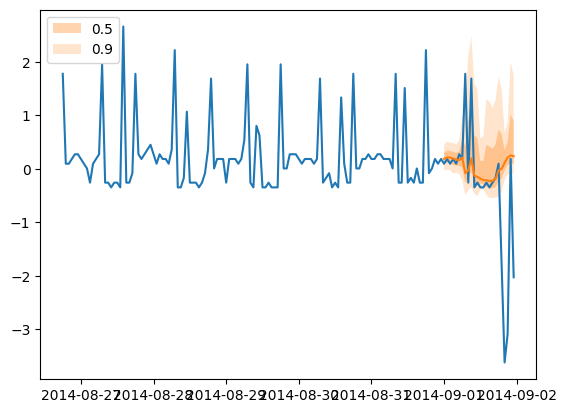

In [17]:
import matplotlib.pyplot as plt

plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [18]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.18142294502685807,
    "abs_error": 327391.5817965269,
    "abs_target_sum": 1115203.6304939985,
    "abs_target_mean": 0.8684574887814211,
    "seasonal_error": 0.32064557889547723,
    "MASE": 0.9321580587026402,
    "MAPE": 1.41848772895549,
    "sMAPE": 0.4463222258486648,
    "MSIS": 8.749315445703552,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.5]": 327391.581785384,
    "Coverage[0.5]": 0.4454396785347164,
    "RMSE": 0.42593772435281907,
    "NRMSE": 0.49045316535927963,
    "ND": 0.2935711226581133,
    "wQuantileLoss[0.5]": 0.29357112264812146,
    "mean_absolute_QuantileLoss": 327391.581785384,
    "mean_wQuantileLoss": 0.29357112264812146,
    "MAE_Coverage": 0.05456032146528361,
    "OWA": NaN
}


In [19]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.5],Coverage[0.5]
0,None,2014-09-01 00:00,1.622798,16.130375,17.943615,0.747651,0.318228,2.112007,0.630257,0.904515,0.0,0.898948,56.254379,16.130375,0.791667
1,None,2014-09-01 01:00,2.164440,19.587057,21.290535,0.887106,0.318228,2.564602,0.615117,0.940151,0.0,0.919989,74.707025,19.587056,0.708333
2,None,2014-09-01 02:00,2.707922,23.194092,24.548990,1.022875,0.317613,3.042758,0.655312,1.029449,0.0,0.944808,91.991990,23.194093,0.750000
3,None,2014-09-01 03:00,3.230649,26.671618,27.807446,1.158644,0.317613,3.498964,0.662420,1.099505,0.0,0.959154,107.692420,26.671617,0.791667
4,None,2014-09-01 04:00,3.780528,30.304361,31.065899,1.294412,0.317613,3.975532,0.708004,1.181416,0.0,0.975486,124.737662,30.304362,0.791667


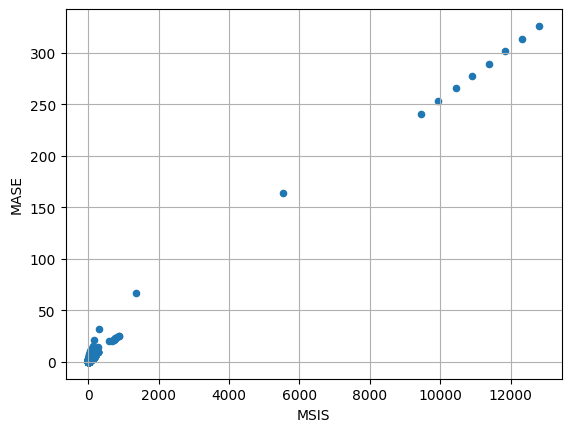

In [20]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()